https://www.youtube.com/watch?v=QpzMWQvxXWk&ab_channel=RobMulla

https://medium.com/analytics-vidhya/sentiment-analysis-on-amazon-reviews-using-tf-idf-approach-c5ab4c36e7a1

# Load Data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from bs4 import BeautifulSoup
import re
import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('popular')
nltk.download('vader_lexicon')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Dataset /Natural Language Processing/Sentiment Analysis/amazon_reviews_us_Jewelry_v1_00.tsv', error_bad_lines = False, sep='\t', header=0)
print(df.shape)

In [3]:
df.head()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,50423057,R135Q3VZ4DQN5N,B00JWXFDMG,657335467,Everbling Purple and Clear Briolette Drop Swar...,Jewelry,5,0.0,0.0,N,Y,Beauties!,so beautiful even tho clearly not high end ......,2015-08-31
1,US,11262325,R2N0QQ6R4T7YRY,B00W5T1H9W,26030170,925 Sterling Silver Finish 6ct Simulated Diamo...,Jewelry,5,0.0,0.0,N,N,Great product.,"Great product.. I got this set for my mother, ...",2015-08-31
2,US,27541121,R3N5JE5Y4T6W5M,B00M2L6KFY,697845240,"Sterling Silver Circle ""Friends Forever"" Infin...",Jewelry,5,0.0,0.0,N,Y,Exactly as pictured and my daughter's friend l...,Exactly as pictured and my daughter's friend l...,2015-08-31
3,US,5350721,R2I150CX5IVY9Q,B0006SW2WU,569859289,Surgical Stainless Steel Domed 9mm Fishbone Ri...,Jewelry,5,0.0,0.0,N,Y,Five Stars,Love it. Fits great. Super comfortable and nea...,2015-08-31
4,US,24484424,R1RM9ICOOA9MQ3,B009YPDW70,332947422,"Sterling Silver Family Pendant Necklace, 18""",Jewelry,5,0.0,0.0,N,Y,... a Mother's Day gift for my Mom and she lov...,Got this as a Mother's Day gift for my Mom and...,2015-08-31


# Exploratory Data Analysis 

In [3]:
df = df[['star_rating','review_body']]

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1766992 entries, 0 to 1766991
Data columns (total 2 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   star_rating  object
 1   review_body  object
dtypes: object(2)
memory usage: 27.0+ MB


Remove the Null, missing values and reset the index



In [ ]:
df.isnull().sum()

star_rating      9
review_body    244
dtype: int64

In [4]:
df=df.dropna()
df = df.reset_index(drop=True)

In [5]:
#convert the star_rating column to int
df['star_rating']=df['star_rating'].astype(int) 

In [ ]:
count_score = df['star_rating'].value_counts().sort_index()
count_score

1     155002
2     100797
3     159654
4     270424
5    1080871
Name: star_rating, dtype: int64

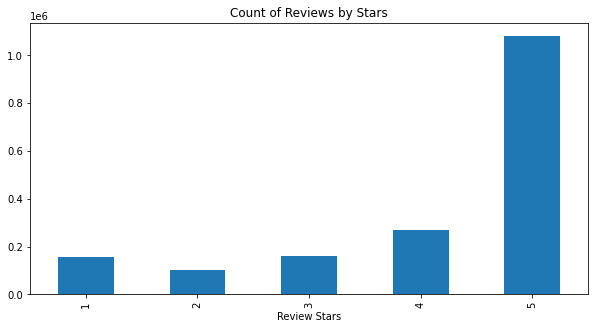

In [ ]:
ax = count_score.plot(kind='bar', title='Count of Reviews by Stars', figsize=(10, 5))
ax.set_xlabel('Review Stars')
plt.show()

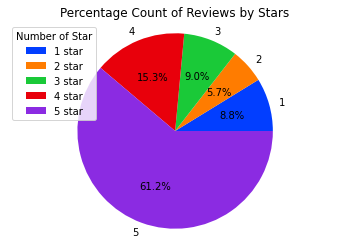

In [ ]:
plt.pie(count_score, labels = ['1','2','3','4','5'], colors = sns.color_palette('bright')[0:], autopct='%1.1f%%', radius = 2)
plt.title('Percentage Count of Reviews by Stars')
plt.legend(loc = 'upper left', labels = ['1 star','2 star','3 star','4 star','5 star'], title = 'Number of Star')
plt.axis('equal')
plt.show()

Set labels

In [6]:
#set the label 1 - Positive when 4,5 star; 0 - Neutral when 3 star, -1 - Negative for others
df['label']=np.where(df['star_rating']>=4,1,np.where(df['star_rating']==3,0,-1))

Now we shuffle the reviews as to take random 150000 reviews for 3 labels and having the same size of sample

In [7]:
df = df.sample(frac=1).reset_index(drop=True) #shuffle
data=df[df['label']==1][:50000]
data=data.append(df[df['label']==-1][:50000])
data=data.append(df[df['label']==0][:50000])

data = data.reset_index(drop=True)
display(data['label'].value_counts())
data

 1    50000
-1    50000
 0    50000
Name: label, dtype: int64

,star_rating,review_body,label
0,4,What a bargain! A lovely ring at an incredibl...,1
1,5,"Very pretty earrings, and not heavy, which I w...",1
2,4,Very beautiful earrings. I did not like the w...,1
3,5,love it and it arrived so fast,1
4,5,Looks better than the pics,1
...,...,...,...
149995,3,This is so cute but the heart is way too big f...,0
149996,3,"This ring was my most favorite style, fit & fe...",0
149997,3,"I bought it for my husband, but it did not fit...",0
149998,3,Not impressed with the metal. The design is gr...,0


#Data Preprocessing

https://www.analyticsvidhya.com/blog/2021/06/text-preprocessing-in-nlp-with-python-codes/

Convert all Review into lower case

In [8]:
data['preprocess'] = data['review_body'].apply(lambda x: " ".join(x.lower() for x in str(x).split()))

In [9]:
data[['preprocess','review_body']].head(3)

,preprocess,review_body
0,exactly what i expected! very nice.,Exactly what I expected! Very nice.
1,i bought this for a gift and the recipient lov...,I bought this for a gift and the recipient lov...
2,my wife loves it!,My wife loves it!


Remove the HTML tags and URLs from the reviews.

In [ ]:
data['preprocess']=data['preprocess'].apply(lambda x: BeautifulSoup(x).get_text())

data['preprocess']=data['preprocess'].apply(lambda x: re.sub(r'http\S+', '', x))

Perform the Contractions on the reviews.
For instance, we will have "I am analyzing sentiment" instead of "I'm analyzing sentiment"

but for some example, It's hard to deal with "ain't": "am not / are not / is not / has not / have not"


https://medium.com/@lukei_3514/dealing-with-contractions-in-nlp-d6174300876b

I try to install Pycontractions package (Its better than Contractions package) but the package have some issue (not because of pip) itself, so I use Contractions package

In [ ]:
!pip install contractions

In [10]:
import contractions 

data['preprocess']=data['preprocess'].apply(lambda x:contractions.fix(x))

Tokenization

In [29]:
print(nltk.word_tokenize(data['preprocess'][0]))

['exactly', 'what', 'i', 'expected', '!', 'very', 'nice', '.']


In [30]:
tagged = nltk.pos_tag(nltk.word_tokenize(data['preprocess'][0]))
tagged[:10]

[('exactly', 'RB'),
 ('what', 'WP'),
 ('i', 'NN'),
 ('expected', 'VBD'),
 ('!', '.'),
 ('very', 'RB'),
 ('nice', 'JJ'),
 ('.', '.')]

Remove non-alpha characters such as symbol "@", comma "," ...

In [11]:
data['preprocess']=data['preprocess'].apply(lambda x: " ".join([re.sub('[^A-Za-z]+','', x) for x in nltk.word_tokenize(x)]))

Remove the extra spaces between the words

In [12]:
data['preprocess'] = data['preprocess'].apply(lambda x: re.sub(' +',' ',x))

Remove the stopwords by using NLTK package

In [13]:
from nltk.corpus import stopwords
stop_w = stopwords.words('english')
data['preprocess'] = data['preprocess'].apply(lambda x: " ".join([x for x in x.split() if x not in stop_w]))

Perform lemmatization using the wordnet lemmatizer



In [14]:
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
data['preprocess'] = data['preprocess'].apply(lambda x: " ".join([lemmatizer.lemmatize(w) for w in nltk.word_tokenize(x)]))

Now let's take a look the original review and the processed review

In [36]:
pd.set_option('display.max_colwidth', None)
data[['review_body','preprocess']][:5]

,review_body,preprocess
0,Exactly what I expected! Very nice.,exactly expected nice
1,I bought this for a gift and the recipient loves the pearls mixed with the amethysts. It is delicate with small pearls and amethysts. I want one for me.,bought gift recipient love pearl mixed amethyst delicate small pearl amethyst want one
2,My wife loves it!,wife love
3,Make a wonderful gift which is why I bought them. Can't wait to see the look on my friends face when she opens up these. I actually went back and bought myself something similar.,make wonderful gift bought wait see look friend face open actually went back bought something similar
4,"easy to place on ear, no irritating issues, love the color, the design and the light weight feel of this product, so great to show off, a great discussion piece for anyone who wants more on their ear without adding holes. definitely recommend to purchase.",easy place ear irritating issue love color design light weight feel product great show great discussion piece anyone want ear without adding hole definitely recommend purchase


https://towardsdatascience.com/dynamic-word-tokenization-with-regex-tokenizer-801ae839d1cd

#Feature Extraction

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression

from sklearn import metrics
from wordcloud import WordCloud 

There is many way to extract feature: bag of words, word2Vec, TF-IDF,... https://www.analyticsvidhya.com/blog/2021/07/feature-extraction-and-embeddings-in-nlp-a-beginners-guide-to-understand-natural-language-processing/

But It seem likes TF-IDF is better for common use cases

https://medium.com/analytics-vidhya/fundamentals-of-bag-of-words-and-tf-idf-9846d301ff22

https://www.analyticsvidhya.com/blog/2020/02/quick-introduction-bag-of-words-bow-tf-idf/#:~:text=Bag%20of%20Words%20just%20creates,less%20important%20ones%20as%20well.

TF - IDF Vectorizer 

In [16]:
X_train, X_test, y_train, y_test = train_test_split(data['preprocess'], data['label'], test_size = 0.25, random_state = 0)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((112500,), (37500,), (112500,), (37500,))

In [17]:
tf_idf_vectorizer =  TfidfVectorizer()
tf_x_train = tf_idf_vectorizer.fit_transform(X_train)
tf_x_test = tf_idf_vectorizer.transform(X_test)

Optional: Using Bag of Word

In [ ]:
# count_vect = CountVectorizer()
# tf_x_train = count_vect.fit_transform(X_train)
# tf_x_test = count_vect.transform(X_test)

#****** or for original text review
# from nltk.tokenize import RegexpTokenizer
# token = RegexpTokenizer(r'[a-zA-Z0-9]+')
# cv = CountVectorizer(stop_words='english',ngram_range = (1,1),tokenizer = token.tokenize)
# text_counts = cv.fit_transform(data['review_body'])

# X_train, X_test, y_train, y_test = train_test_split(text_counts, data['label'], test_size = 0.25, random_state = 0)
# X_train.shape, X_test.shape, y_train.shape, y_test.shape

# Implement Machine Learning Model

## Suport Vector Machine

In [22]:
SVM_model = LinearSVC()
SVM_model.fit(tf_x_train, y_train)

y_test_predicted = SVM_model.predict(tf_x_test)

              precision    recall  f1-score   support

          -1       0.70      0.74      0.72     12417
           0       0.62      0.56      0.59     12682
           1       0.78      0.82      0.80     12401

    accuracy                           0.70     37500
   macro avg       0.70      0.70      0.70     37500
weighted avg       0.70      0.70      0.70     37500



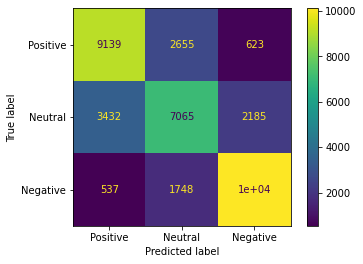

In [23]:
report = metrics.classification_report(y_test, y_test_predicted)
print(report)
cm = metrics.confusion_matrix(y_test,y_test_predicted)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ['Positive','Neutral','Negative'])
cm_display.plot()
plt.show()

## Logistic Regression

In [ ]:
LogR_model = LogisticRegression(random_state = 42)
LogR_model.fit(tf_x_train, y_train)

y_test_predicted = LogR_model.predict(tf_x_test)

              precision    recall  f1-score   support

          -1       0.72      0.73      0.73     12417
           0       0.62      0.61      0.61     12682
           1       0.80      0.82      0.81     12401

    accuracy                           0.72     37500
   macro avg       0.72      0.72      0.72     37500
weighted avg       0.72      0.72      0.72     37500



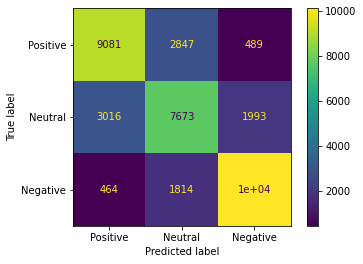

In [19]:
report = metrics.classification_report(y_test, y_test_predicted)
print(report)
cm = metrics.confusion_matrix(y_test,y_test_predicted)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ['Positive','Neutral','Negative'])
cm_display.plot()
plt.show()

## Multinomial Naive Bayes

In [20]:
MNB_model = MultinomialNB()
MNB_model.fit(tf_x_train, y_train)

y_test_predicted = MNB_model.predict(tf_x_test)

              precision    recall  f1-score   support

          -1       0.72      0.69      0.70     12417
           0       0.59      0.63      0.61     12682
           1       0.80      0.77      0.79     12401

    accuracy                           0.70     37500
   macro avg       0.70      0.70      0.70     37500
weighted avg       0.70      0.70      0.70     37500



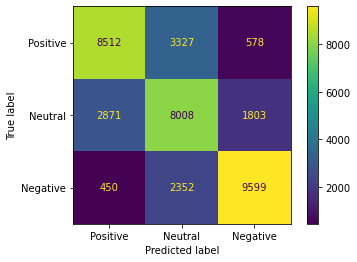

In [21]:
report = metrics.classification_report(y_test, y_test_predicted)
print(report)
cm = metrics.confusion_matrix(y_test,y_test_predicted)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ['Positive','Neutral','Negative'])
cm_display.plot()
plt.show()

##Fun fact: let see how frequency of words in Positive Review

You can replace data['label'] == 0 or -1 to see another label

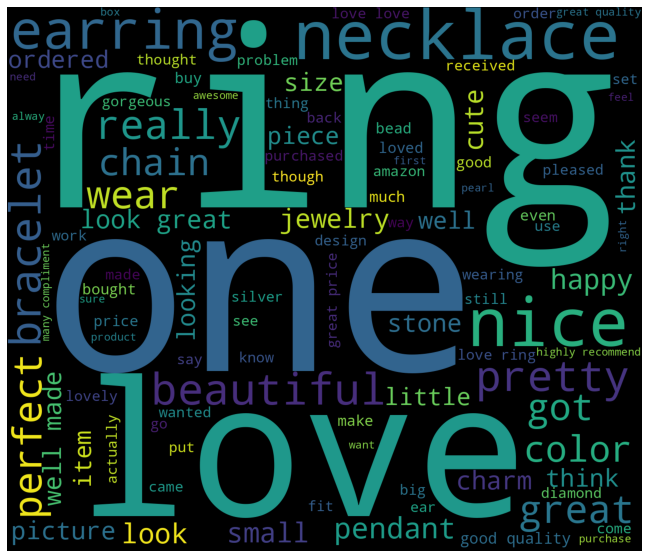

In [24]:
w_cloud = ' '.join(word for word in data['preprocess'][data['label']==1].astype(str))
plt.subplots(figsize=(15,10))
wordcloud = WordCloud(
                          background_color='black',
                          max_words=100,
                          width=1400,
                          height=1200
                         ).generate(w_cloud)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

#The end